In [1]:
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.initializers import RandomNormal
from copy import deepcopy
import numpy as np
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from numpy.random import choice
import copy

In [2]:
#load cifar10 dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#convert labels to one hot encodings
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#normalize the data
x_train = x_train/255.0
x_test = x_test/255.0

x_test_display = x_test
y_test_display = y_test

x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

In [3]:
#load cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
#normalize input images
x_train = x_train/255.0
x_test = x_test/255.0
#one hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
x_train, y_train = shuffle(x_train, y_train)
x_small = x_train[:5000]
y_small = y_train[:5000]
x_train, y_train = shuffle(x_train, y_train)

In [4]:
class conv_net:
    def __init__(self,
                 input_shape, 
                conv_layer_filters,
                conv_layer_kernel_size,
                conv_layer_strides,
                initializer_mean,
                intializer_stdev):
        self.input_shape = input_shape
        self.conv_layer_filters = conv_layer_filters
        self.conv_layer_kernel_size = conv_layer_kernel_size
        self.conv_layer_strides = conv_layer_strides
        self.initializer_mean = initializer_mean
        self.intializer_stdev = intializer_stdev
        self._build()
        
    
    def _build(self):
        input_layer = Input(shape=self.input_shape)
        x = input_layer
        for i in range(len(self.conv_layer_filters)):
            x = Conv2D(filters=self.conv_layer_filters[i],
                      kernel_size=self.conv_layer_kernel_size[i],
                      strides=self.conv_layer_strides[i],
                       padding='same',
                      kernel_initializer=RandomNormal(mean=self.initializer_mean, stddev=self.intializer_stdev)\
                      )(x)
            x = BatchNormalization()(x)
            x = LeakyReLU()(x)
        
        x = Flatten()(x)
        output_layer = Dense(10, activation='softmax', \
                             kernel_initializer=RandomNormal(mean=self.initializer_mean, stddev=self.intializer_stdev)\
                            )(x)
        self.model = Model(input_layer, output_layer)
        
    def compile(self):
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
        
    def train(self, x_train, y_train, epochs=1):
        self.model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=32, shuffle=True)
    
    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

In [8]:
class darwin_net:
    def __init__(self, neural_net,
                num_genomes_per_gen,
                num_generations,
                x_train, y_train,
                keep_n_best,
                mutation_prob=0.2):
        self.neural_net = neural_net
        self.num_genomes_per_gen = num_genomes_per_gen
        self.num_generations = num_generations
        
        self.x_train = x_train
        self.y_train = y_train
        self.generation = 1
        #if keep_n_best is int then that many best genomes will be retained in each generation
        #if keep_n_best is a float (between 0 and 1) then that % of best  genomes will be retained in each generation
        self.keep_n_best = keep_n_best
        self.mutation_prob = mutation_prob
        self.genomes = self._build()
        self.run()
        
    def build_neural_net(self, initializer_mean, initializer_stdev):
        cnet = self.neural_net(input_shape=self.x_train.shape[1:],\
                         conv_layer_filters=[16, 32, 32],\
                        conv_layer_kernel_size=[3,3,3],\
                        conv_layer_strides=[1,1,1],\
                        initializer_mean = initializer_mean,\
                        intializer_stdev = initializer_stdev)
        cnet.compile()
        return cnet
        
    def _build(self):
        #create num_genomes_per_gen number of conv_nets in a loop with random initialization
        genomes = []
        initializer_mean = 0.
        initializer_stdev = 1.
        for i in range(self.num_genomes_per_gen):
            if i>0:
                initializer_mean += 0.01
                initializer_stdev += 0.01
            cnet = self.build_neural_net(initializer_mean, initializer_stdev)
            genomes.append(cnet)
        return genomes
    
    
    
    def evaluate_generation(self):
        results = []
        self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
        for i in range(len(self.genomes)):
            genome = self.genomes[i]
            
            results.append(genome.evaluate(self.x_train, self.y_train)+[i])
        return results
    
    
    def keep_best_genomes(self, results):
        results = sorted(results, key=lambda x: x[1], reverse=True)
        
        #keep the top N %
        if type(self.keep_n_best) == int:
            if self.keep_n_best >= self.num_genomes_per_gen:
                self.keep_n_best = self.num_genomes_per_gen-1
        else:
            if self.keep_n_best > 0.9999:
                self.keep_n_best = 0.9
            self.keep_n_best = int(self.num_genomes_per_gen*self.keep_n_best)

        results = results[:self.keep_n_best]
        return results
    
    def _make_model_copy(self, model):
        #create a new model and copy the weights of the passed model to the new model
        model_copy = self.build_neural_net(initializer_mean=0., initializer_stdev=1.)
        model_copy.model.set_weights(model.model.get_weights())
        return model_copy
    
    def _get_random_slice_point(self, model):
        #get a random slice point to slice the model to achieve the crossover between 2 models
        #the slice point can only be a conv layer or a dense layer (cannot be input, batchnorm or dropout layers)
        while True:
            random_slice_point_layer = random.randint(1,len(model.model.layers)-1)
            layer_name = model.model.layers[random_slice_point_layer].name
            if 'conv' in layer_name or 'dense' in layer_name:
                break
        return random_slice_point_layer
    
    def _do_crossover(self, model1, model2, slice_point):
        #swap all the layers in 2 models after the slice_point layer
        '''for i in range(slice_point, len(model1.model.layers)):
            model1_layer_weights = copy.deepcopy(model1.model.layers[i].get_weights())
            model1.model.layers[i].set_weights(model2.model.layers[i].get_weights())
            model2.model.layers[i].set_weights(model1_layer_weights)'''
        return model1, model2
    
    def crossover(self, parents):
        #make copy of the parents
        model1 = self.genomes[parents[0]]
        model2 = self.genomes[parents[1]] 
        model1_copy = self._make_model_copy(model1)
        model2_copy = self._make_model_copy(model2)
        
        #get a slice point to swap layers
        slice_point = self._get_random_slice_point(model1)
        
        #swap layers across slice point
        model1_copy, model2_copy = self._do_crossover(model1_copy, model2_copy, slice_point)
        
        #put the new crossover models to the genome for next generation
        self.genomes.append(model1_copy)
        self.genomes.append(model2_copy)
        
    def mutate(self, dont_mutate_parents=True):
        #mutate some neurons in the models
        #if dont_mutate_parents is False the parent models are mutated 
        start_index = self.keep_n_best if dont_mutate_parents else 0
        for i in range(start_index, len(self.genomes)):
            #mutate layers
            for j in range(len(self.genomes[0].model.layers)):
                if random.random() < self.mutation_prob:
                    #adjust the bias multiplying a random number in the random -2:2
                    #I don't know why everyone follows the above rule of -2:+2. 
                    #Have to investigate more
                    layer_name = self.genomes[i].model.layers[j].name
                    if 'conv' in layer_name or 'dense' in layer_name:
                        weights = self.genomes[i].model.layers[j].get_weights()
                        #add random values to weights
                        weights[0] += weights[0] * (random.random() - 0.5) * 3 + (random.random() - 0.5)
                        #add random values to bias
                        weights[1] += weights[1] * (random.random() - 0.5) * 3 + (random.random() - 0.5)
                        self.genomes[i].model.layers[j].set_weights(weights)
                    
    def create_next_generation(self, results):
        self.generation += 1
        results = self.keep_best_genomes(results)
        probs = [r[1] for r in results]
        probs_sum = sum(probs)
        prob_dist = [p/probs_sum for p in probs]
        self.genomes = [self.genomes[i] for _,_,i in results]
        
        for i in range((self.num_genomes_per_gen-len(results))//2):
            draw2 = choice(len(results), size=2, replace=False, p=prob_dist)
            self.crossover(draw2)
        self.mutate(dont_mutate_parents=True)
        
    def run(self):
        for i in range(self.num_generations-1):
            print('Executing generation : ', (i+1))
            results = self.evaluate_generation()
            self.create_next_generation(results)
            

In [9]:
dnet = darwin_net(neural_net=conv_net,
                num_genomes_per_gen=10,
                num_generations=100,
                x_train=x_small, y_train=y_small,
                keep_n_best=3,
                mutation_prob=0.8)

Executing generation :  1
5000/5000 [==============================] - 4s 875us/sample - loss: 68167.6104 - acc: 0.1462
Executing generation :  2
5000/5000 [==============================] - 4s 875us/sample - loss: 330409.0700 - acc: 0.0568
Executing generation :  3
5000/5000 [==============================] - 4s 897us/sample - loss: 16325.9229 - acc: 0.0818
Executing generation :  4
5000/5000 [==============================] - 5s 904us/sample - loss: 31454.4969 - acc: 0.0864
Executing generation :  5
5000/5000 [==============================] - 5s 922us/sample - loss: 2276142.1652 - acc: 0.0514
Executing generation :  6
5000/5000 [==============================] - 5s 930us/sample - loss: 41283.0906 - acc: 0.1020
Executing generation :  7
5000/5000 [==============================] - 5s 955us/sample - loss: 1230.4246 - acc: 0.0590
Executing generation :  8
5000/5000 [==============================] - 5s 965us/sample - loss: 65589.9721 - acc: 0.0760
Executing generation :  9
5000/5000 [=

5000/5000 [==============================] - 5s 974us/sample - loss: 2379598.2372 - acc: 0.1126
Executing generation :  11
5000/5000 [==============================] - 5s 979us/sample - loss: 736.0211 - acc: 0.0510
Executing generation :  12
5000/5000 [==============================] - 5s 993us/sample - loss: 51686.8331 - acc: 0.0664
Executing generation :  13
5000/5000 [==============================] - 5s 1ms/sample - loss: 184992.6367 - acc: 0.0500
Executing generation :  14
5000/5000 [==============================] - 5s 1ms/sample - loss: 955581.8740 - acc: 0.2044
Executing generation :  15
5000/5000 [==============================] - 5s 1ms/sample - loss: 1140901.9348 - acc: 0.1016
Executing generation :  16
5000/5000 [==============================] - 5s 1ms/sample - loss: 21093.0505 - acc: 0.1070
Executing generation :  17
5000/5000 [==============================] - 5s 1ms/sample - loss: 172283.9641 - acc: 0.0540
Executing generation :  18
5000/5000 [==========================

5000/5000 [==============================] - 5s 1ms/sample - loss: 72.4585 - acc: 0.1136
Executing generation :  20
5000/5000 [==============================] - 5s 1ms/sample - loss: 137007.1635 - acc: 0.1762
Executing generation :  21
5000/5000 [==============================] - 6s 1ms/sample - loss: 7536343.8240 - acc: 0.1814
Executing generation :  22
5000/5000 [==============================] - 6s 1ms/sample - loss: 68730.0453 - acc: 0.1556
Executing generation :  23
5000/5000 [==============================] - 6s 1ms/sample - loss: 25640.7401 - acc: 0.0740
Executing generation :  24
5000/5000 [==============================] - 14s 3ms/sample - loss: 215.8544 - acc: 0.2164
Executing generation :  25
5000/5000 [==============================] - 14s 3ms/sample - loss: 85261.4069 - acc: 0.0534
Executing generation :  26
5000/5000 [==============================] - 14s 3ms/sample - loss: 153532.0005 - acc: 0.0564
Executing generation :  27
5000/5000 [==============================] - 1

5000/5000 [==============================] - 6s 1ms/sample - loss: 319110.5310 - acc: 0.1884
Executing generation :  30
5000/5000 [==============================] - 6s 1ms/sample - loss: 508554.1060 - acc: 0.1980
Executing generation :  31
5000/5000 [==============================] - 6s 1ms/sample - loss: 375693.9236 - acc: 0.1794
Executing generation :  32
5000/5000 [==============================] - 6s 1ms/sample - loss: 229264.9296 - acc: 0.1094
Executing generation :  33
5000/5000 [==============================] - 6s 1ms/sample - loss: 9025.4549 - acc: 0.1738
Executing generation :  34
5000/5000 [==============================] - 6s 1ms/sample - loss: 41689.5565 - acc: 0.1830
Executing generation :  35
5000/5000 [==============================] - 6s 1ms/sample - loss: 934097.4316 - acc: 0.2320
Executing generation :  36
5000/5000 [==============================] - 6s 1ms/sample - loss: 142450.7191 - acc: 0.2064
Executing generation :  37
5000/5000 [==============================] 

5000/5000 [==============================] - 7s 1ms/sample - loss: 171563.0336 - acc: 0.1126
Executing generation :  39
5000/5000 [==============================] - 7s 1ms/sample - loss: 15388.7318 - acc: 0.0514
Executing generation :  40
5000/5000 [==============================] - 7s 1ms/sample - loss: 1000341.3568 - acc: 0.0540
Executing generation :  41
5000/5000 [==============================] - 7s 1ms/sample - loss: 1626415.2758 - acc: 0.1016
Executing generation :  42
5000/5000 [==============================] - 7s 1ms/sample - loss: 10711.7201 - acc: 0.1016
Executing generation :  43
5000/5000 [==============================] - 7s 1ms/sample - loss: 36382.8558 - acc: 0.1016
Executing generation :  44
5000/5000 [==============================] - 7s 1ms/sample - loss: 12650.0388 - acc: 0.0524
Executing generation :  45
5000/5000 [==============================] - 7s 1ms/sample - loss: 5160.9371 - acc: 0.0504
Executing generation :  46
5000/5000 [==============================] -

5000/5000 [==============================] - 7s 1ms/sample - loss: 185301.4261 - acc: 0.0470
Executing generation :  48
5000/5000 [==============================] - 7s 1ms/sample - loss: 14198186.7648 - acc: 0.1900
Executing generation :  49
5000/5000 [==============================] - 7s 1ms/sample - loss: 4743305.3912 - acc: 0.1016
Executing generation :  50
5000/5000 [==============================] - 7s 1ms/sample - loss: 180643.7058 - acc: 0.0848
Executing generation :  51
5000/5000 [==============================] - 7s 1ms/sample - loss: 609770.3284 - acc: 0.1008
Executing generation :  52
5000/5000 [==============================] - 7s 1ms/sample - loss: 21540.9660 - acc: 0.0536
Executing generation :  53
5000/5000 [==============================] - 7s 1ms/sample - loss: 189394.6428 - acc: 0.1956
Executing generation :  54
5000/5000 [==============================] - 7s 1ms/sample - loss: 1312818.5467 - acc: 0.1164
Executing generation :  55
5000/5000 [==========================

5000/5000 [==============================] - 8s 2ms/sample - loss: 392160.6456 - acc: 0.2222
Executing generation :  58
5000/5000 [==============================] - 8s 2ms/sample - loss: 59835678.7968 - acc: 0.0982
Executing generation :  59
5000/5000 [==============================] - 8s 2ms/sample - loss: 520950.0781 - acc: 0.0612
Executing generation :  60
5000/5000 [==============================] - 8s 2ms/sample - loss: 5512812.0512 - acc: 0.0518
Executing generation :  61
5000/5000 [==============================] - 8s 2ms/sample - loss: 163933614.7968 - acc: 0.0928


In [37]:
choice(3, size=2, replace=False, p=[0.36180555510642237, 0.37222221719193044, 0.2659722277016472])

array([1, 0])

In [ ]:
x_train = x_train[:5000]
y_train = y_train[:5000]

In [ ]:

min_loss = float('INF')

highest_acc_ever = 0
lowest_loss_ever = min_loss
best_candidate = None
head_of_last_five_generations = []
max_acc = 0.
for it in range(2000):
    print('Iteration : ', it)
    x_train, y_train = shuffle(x_train, y_train)
    results = []
    #run inference on all the 5 dnets
    best_candidate_prev = best_candidate
    
    
    
    max_acc = 0.
    for i in range(len(dnets)):
        #if i != best_candidate_prev or best_candidate_prev is None :
        #    dnets[i].train(x_small, y_small)
        results.append(dnets[i].evaluate(x_train, y_train)+[i])
        
        #optimize for minimal loss
        '''if results[i][0] < min_loss:
            min_loss = results[i][0]
            best_candidate = i'''
        
        #optimize for maximizing accuracy
        if results[i][1] > max_acc:
            max_acc = results[i][1]
            best_candidate = i
        if results[i][1] > highest_acc_ever:
            highest_acc_ever = results[i][1]
        if lowest_loss_ever > results[i][0]:
            lowest_loss_ever = results[i][0]
        
    head_of_last_five_generations.append((best_candidate, max_acc))
    if len(head_of_last_five_generations)==6 and len(set(head_of_last_five_generations))==1:
        print('Same parent for the last 5 generations. Choosing a different parent')
        best_candidate = sorted(results)[-2][2]
        head_of_last_five_generations = []
    else:
        if len(head_of_last_five_generations) >5:
            head_of_last_five_generations.pop(0)
    print(min_loss,max_acc, best_candidate,  highest_acc_ever, lowest_loss_ever)
    
    #extract the weights of the best candidate
    best_model = dnets[best_candidate].model

    mu = 0.
    sigma = 1.
    for i in range(len(dnets)):
        if i==best_candidate:
            continue
        
        #mu += 0.01
        #sigma += 0.1
        
        model = dnets[i].model
        while True:
            random_layer_be_changed = random.randint(1,len(model.layers)-1)
            layer_name = model.layers[random_layer_be_changed].name
            if 'conv' in layer_name or 'dense' in layer_name:
                break
                
        #print('Random layer to be changed ', model.layers[random_layer_be_changed].name)
        for k in range(len(model.layers)):
            
            layer = model.layers[k]
            '''if 'batch_normalization' in layer.name:
                continue'''
            best_layer = best_model.layers[k]
            weights = best_layer.get_weights()
            if k==random_layer_be_changed:
                for j in range(len(weights)):
                    #print('before : ', np.sum(weights[j]))

                    if (i+k+j)%2 ==0:
                        #print(f'Model {i} : Layer {k} ; added')
                        weights[j] += np.random.normal(mu, sigma, weights[j].shape)
                    else:
                        #print(f'Model {i} : Layer {k} ; subtracted')
                        weights[j] -= np.random.normal(mu, sigma, weights[j].shape)
                    #print('after : ', np.sum(weights[j]))
                    #break
            layer.set_weights(weights)

        dnets[i].model = model
    #[layer.layername() for layer in best_model.layers[1:]]

Iteration :  0
5000/5000 [==============================] - 5s 902us/sample - loss: 227.7359 - acc: 0.0960
inf 0.1292 0 0.1292 186.31073029785156
Iteration :  1
5000/5000 [==============================] - 4s 847us/sample - loss: 249.3279 - acc: 0.1454
inf 0.1508 1 0.1508 186.31073029785156
Iteration :  2
5000/5000 [==============================] - 4s 842us/sample - loss: 34411.8904 - acc: 0.1492
inf 0.1782 0 0.1782 186.31073029785156
Iteration :  3
5000/5000 [==============================] - 4s 863us/sample - loss: 52626.4176 - acc: 0.1762
inf 0.1782 0 0.1782 186.31073029785156
Iteration :  4
5000/5000 [==============================] - 4s 846us/sample - loss: 60989.9387 - acc: 0.1104
inf 0.1782 0 0.1782 186.31073029785156
Iteration :  5
5000/5000 [==============================] - 4s 884us/sample - loss: 41709.8600 - acc: 0.1162
inf 0.1782 0 0.1782 186.31073029785156
Iteration :  6
5000/5000 [==============================] - 4s 895us/sample - loss: 38231.7989 - acc: 0.1376
inf 0.1

Iteration :  31
5000/5000 [==============================] - 5s 1ms/sample - loss: 431841.8712 - acc: 0.2250
inf 0.2396 0 0.2396 186.31073029785156
Iteration :  32
5000/5000 [==============================] - 5s 961us/sample - loss: 358730.4242 - acc: 0.1898
inf 0.2396 0 0.2396 186.31073029785156
Iteration :  33
5000/5000 [==============================] - 5s 920us/sample - loss: 303116.8868 - acc: 0.1832
inf 0.2396 0 0.2396 186.31073029785156
Iteration :  34
5000/5000 [==============================] - 4s 810us/sample - loss: 388955.7734 - acc: 0.2084
inf 0.2396 0 0.2396 186.31073029785156
Iteration :  35
5000/5000 [==============================] - 4s 780us/sample - loss: 434327.5415 - acc: 0.1452
inf 0.2422 2 0.2422 186.31073029785156
Iteration :  36
5000/5000 [==============================] - 4s 869us/sample - loss: 645875.6820 - acc: 0.2292
inf 0.2432 1 0.2432 186.31073029785156
Iteration :  37
5000/5000 [==============================] - 4s 874us/sample - loss: 677838.9844 - acc

In [7]:
best_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 243us/sample - loss: 109929.9581 - acc: 0.1575


[109929.9581, 0.1575]

In [8]:
best_model.evaluate(x_train, y_train)

10000/10000 [==============================] - 4s 363us/sample - loss: 109196.1770 - acc: 0.1656


[109196.177, 0.1656]

In [9]:
#CLASSES = np.array(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
preds = best_model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

In [10]:
dense_layer_bias = best_model.layers[-1].get_weights()[1]
dense_layer_weights = best_model.layers[-1].get_weights()[0]

In [11]:
dense_layer_bias.shape, dense_layer_weights.shape

((10,), (32768, 10))

true label =  ['cat']
predicted label :  ['automobile']
flatten_1
Output of flatten layer :  [[ -31.27567  -111.20358   241.37512  ...   92.415115  -60.16829
   -50.92895 ]]
dense_1
Output of dense layer :  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


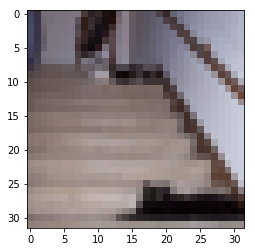

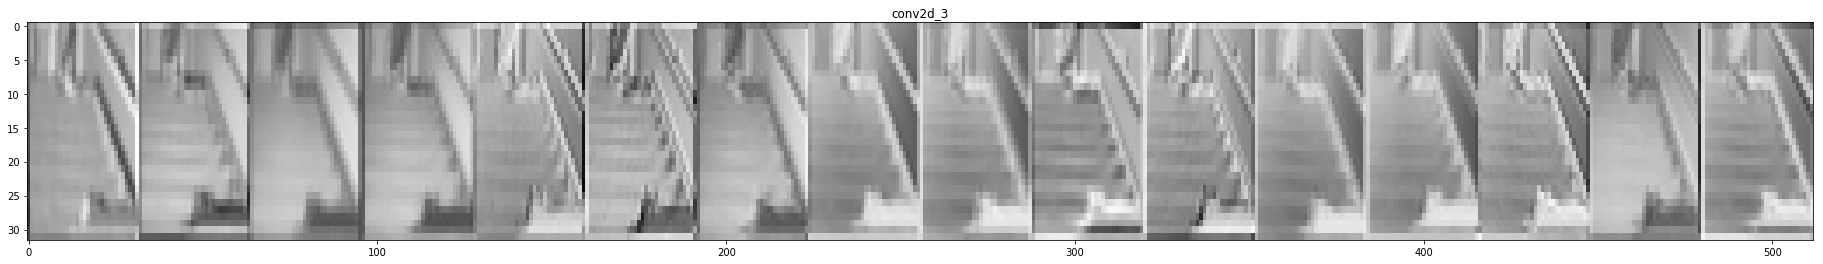

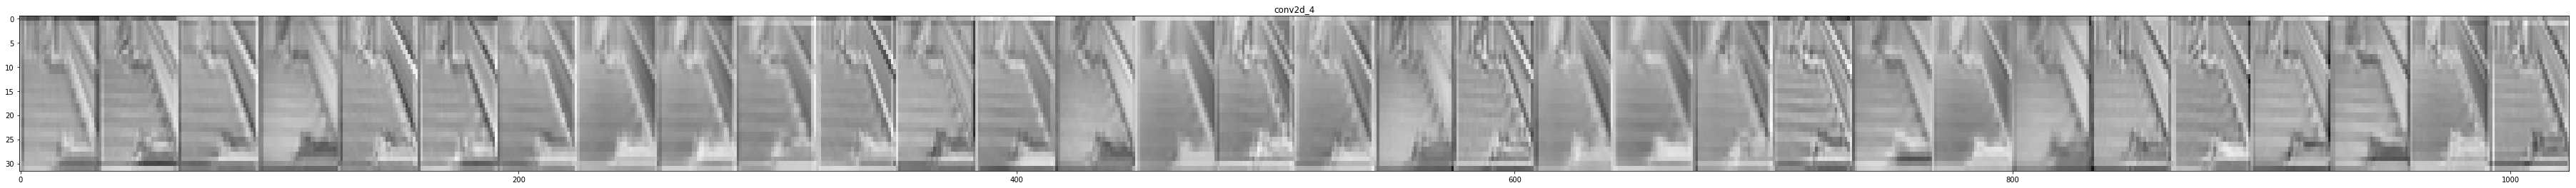

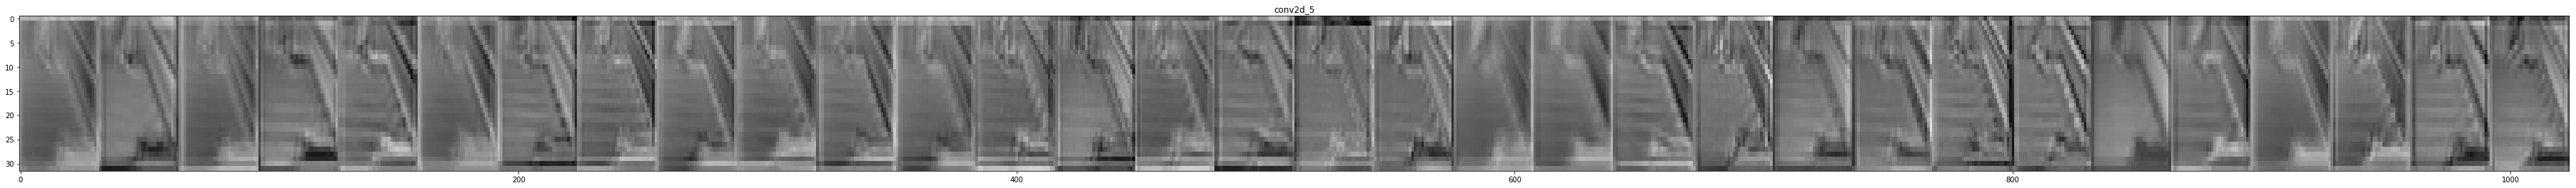

In [20]:
import numpy as np
import random

#new model that outputs each layer's feature maps
successive_outputs = [layer.output for layer in best_model.layers[1:]]
viz_model = Model(best_model.input, successive_outputs)
n_to_show = 1

#select an image and display
idx = np.random.choice(range(len(x_test)), n_to_show)
#img = x_test_display[idx[0]]
img = x_test[idx[0]]
print("true label = ",str(actual_single[idx]))
print('predicted label : ', str(preds_single[idx]))
plt.imshow(img, cmap='Greys')

#run the image thorugh the model
img = x_test[idx]
#img = img/255
successive_feature_maps = viz_model.predict(img)

layer_names = [layer.name for layer in best_model.layers[1:]]
flatten_layer_output = None

#display feature maps
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
    if "dense" in layer_name:
        print(layer_name)
        print("Output of dense layer : ", feature_map)
    
    if "flatten" in layer_name:
        print(layer_name)
        print("Output of flatten layer : ", feature_map)
        flatten_layer_output = feature_map
        
    if len(feature_map.shape) == 4 and "conv" in layer_name:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        
        display_grid = np.zeros(( size, size*n_features))
        
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            display_grid[:, i*size : (i+1)*size] = x
            
        #scale = 60. / n_features
        #print(scale)
        scale = 2
        plt.figure(figsize=(scale*n_features, scale*2))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='Greys')

In [18]:
dense_layer_output_manual = np.dot(flatten_layer_output, dense_layer_weights) + dense_layer_bias

In [20]:
flatten_layer_output[0]

array([-0.08716337,  0.13332915,  0.40264612, ..., -0.30247527,
        1.044758  , -0.31335896], dtype=float32)

In [21]:
dense_layer_output_manual

array([[ 1.2049246 ,  0.44478887, -1.4002323 , -0.27973223,  1.621755  ,
        -1.1021218 , -0.8606808 , -1.3452501 , -3.0433302 ,  0.14648888]],
      dtype=float32)

In [22]:
from scipy.special import softmax
softmax(dense_layer_output_manual)

array([[0.2531087 , 0.1183544 , 0.01870259, 0.0573494 , 0.3840027 ,
        0.0251982 , 0.03207939, 0.0197597 , 0.00361671, 0.08782827]],
      dtype=float32)

In [126]:
sum(np.exp(dense_layer_output_manual))

/home/poornav/anaconda3/envs/generative/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([ 0., inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [127]:
from sklearn.metrics import log_loss
log_loss(y_test[idx], softmax(dense_layer_output_manual))

34.53877639770508

In [128]:
y_test[idx]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [129]:
preds[idx]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
set(preds_single)

NameError: name 'preds_single' is not defined

In [10]:
set(actual_single)

NameError: name 'actual_single' is not defined

In [121]:
sum([1 if l == 'nine' else 0 for l in actual_single])

1009

true label =  ['four']
predicted label :  ['six']


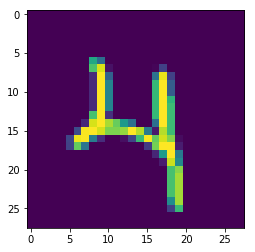

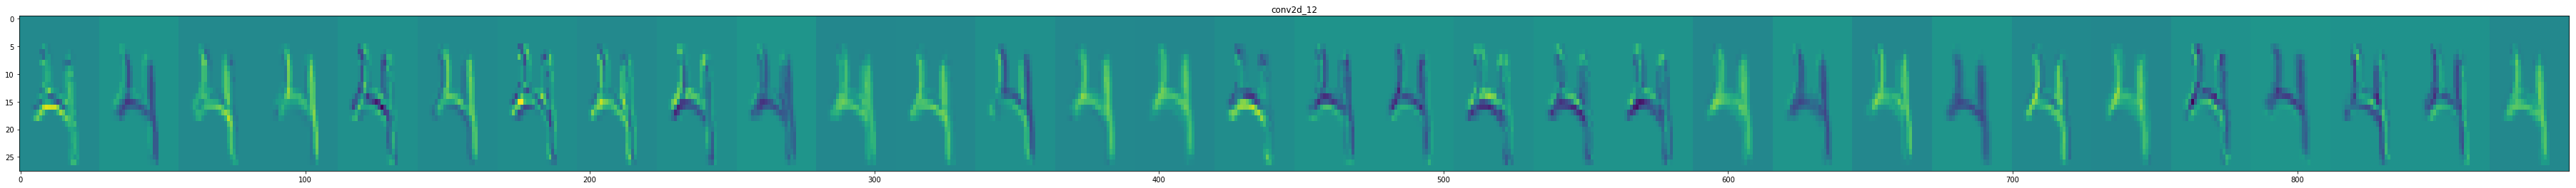

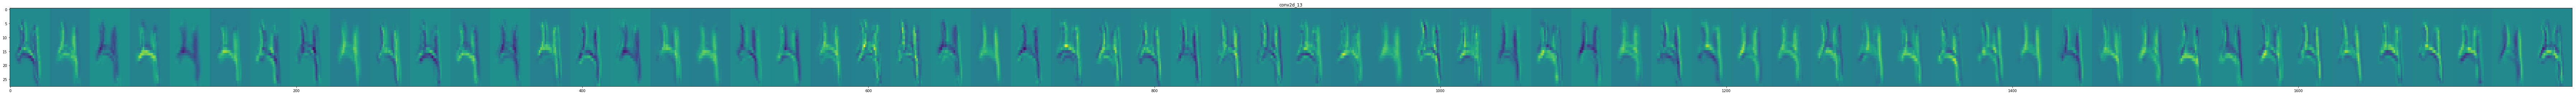

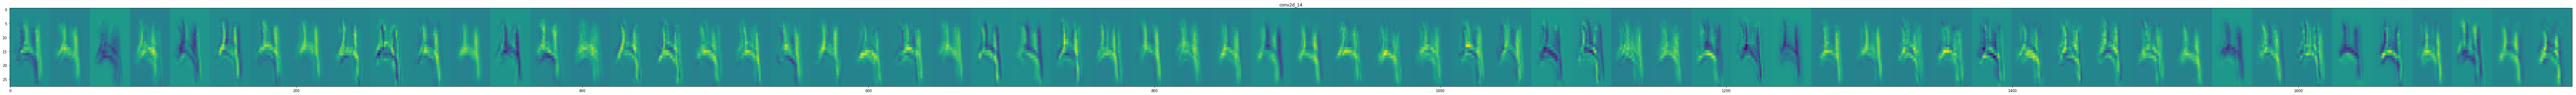

In [12]:
import numpy as np
import random

#new model that outputs each layer's feature maps
successive_outputs = [layer.output for layer in model.layers[1:]]
viz_model = Model(model.input, successive_outputs)
n_to_show = 1

#select an image and display
idx = np.random.choice(range(len(x_test)), n_to_show)
img = x_test_display[idx[0]]
print("true label = ",str(actual_single[idx]))
print('predicted label : ', str(preds_single[idx]))
plt.imshow(img)

#run the image thorugh the model
img = x_test[idx]
img = img/255
successive_feature_maps = viz_model.predict(img)

layer_names = [layer.name for layer in model.layers]

#display feature maps
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4 and "conv" in layer_name:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        
        display_grid = np.zeros(( size, size*n_features))
        
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            display_grid[:, i*size : (i+1)*size] = x
            
        #scale = 60. / n_features
        #print(scale)
        scale = 2
        plt.figure(figsize=(scale*n_features, scale*2))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [7]:
best_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 28, 28, 64)        0   

In [92]:
#extract the weights of the best candidate
best_model = dnets[best_candidate].model

mu = 0.
sigma = 0.01
for i in range(len(dnets)):
    if i==best_candidate:
        continue
    mu += 0.01
    sigma += 0.01
    model = dnets[i].model
    for k in range(len(model.layers)):
        layer = model.layers[k]
        best_layer = best_model.layers[k]
        weights = best_layer.get_weights()
        for j in range(len(weights)):
            print('before : ', np.sum(weights[j]))
            if (i+k)%2 ==0:
                weights[j] += np.random.normal(mu, sigma, weights[j].shape)
            else:
                weights[j] -= np.random.normal(mu, sigma, weights[j].shape)
            print('after : ', np.sum(weights[j]))
            break
        layer.set_weights(weights)
    
    dnets[i].model = model
#[layer.layername() for layer in best_model.layers[1:]]

before :  -52.875854
after :  -49.999702
before :  -2282.0115
after :  -2100.074
before :  -4532.2026
after :  -4167.029
before :  315.6309
after :  292.21835
before :  -52.875854
after :  -58.866547
before :  -2282.0115
after :  -2644.006
before :  -4532.2026
after :  -5277.3887
before :  315.6309
after :  369.6569
before :  -52.875854
after :  -44.28579
before :  -2282.0115
after :  -1731.9463
before :  -4532.2026
after :  -3431.889
before :  315.6309
after :  237.7219
before :  -52.875854
after :  -65.01718
before :  -2282.0115
after :  -3030.6836
before :  -4532.2026
after :  -6019.8843
before :  315.6309
after :  417.26392


In [83]:
weights

[array([[ 0.3881982 ,  0.02703978, -0.29756683, ...,  0.5187003 ,
         -0.37334028, -0.6193479 ],
        [ 0.9073109 ,  1.3086578 ,  1.1529409 , ..., -0.24857974,
         -0.42629373, -1.7063025 ],
        [ 0.21862838,  0.687943  , -1.2418685 , ..., -0.17590262,
         -0.45474738,  1.0146215 ],
        ...,
        [-0.8349551 ,  1.1972718 ,  0.13104965, ..., -0.482081  ,
         -0.18002416,  0.9760484 ],
        [ 0.9530698 ,  0.45497876,  0.8581185 , ..., -1.3804762 ,
         -1.3348916 ,  0.3484456 ],
        [ 1.5237398 , -0.8260814 ,  0.9193674 , ...,  0.01026246,
         -0.37892258,  0.68395936]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [36]:
#extract the weights of the best candidate
best_model = dnets[best_candidate].model

#clone the model 5 times
for i in range(len(dnets)):
    if i==best_candidate:
        continue
    dnet = dnets[i]
    dnet.model = clone_model(best_model)
    dnet.compile()
print(min_loss, best_candidate,  highest_acc_ever, lowest_loss_ever)

4207.215662109375 2 0.12691666 4207.215662109375


In [35]:
for dnet in dnets:
    dnet.evaluate(x_train, y_train)

60000/60000 [==============================] - 2s 38us/sample - loss: 4498.1508 - acc: 0.1287


In [6]:
#extract the weights of the best candidate
best_model = dnets[best_candidate].model

mu = 0.
sigma = 0.001
add=True
for i in range(len(dnets)):
    if i==best_candidate:
        continue
    mu += 0.001
    sigma += 0.001
    add |= False
    model = dnets[i].model
    for layer in model.layers[1:]:
        layer = model.layers[k]
        best_layer = best_model.layers[k]
        weights = best_layer.get_weights()
        for j in range(len(weights)):
            print('before : ', np.sum(weights[j]))
            weights[j] = np.random.normal(mu, sigma, weights[j].shape)
            print('after : ', np.sum(weights[j]))
        layer.set_weights(weights)
    
    dnets[i].model = model
#[layer.layername() for layer in best_model.layers[1:]]

SyntaxError: invalid syntax (<ipython-input-6-149386d45bd2>, line 2)

In [51]:
add=False

In [56]:
add &= False

In [57]:
add

False

In [38]:
for dnet in dnets:
    dnet.evaluate(x_train, y_train)

49280/60000 [=======================>......] - ETA: 0s - loss: nan - acc: 0.0986

KeyboardInterrupt: 

In [90]:
w=l.get_weights()

In [101]:
l.set_weights()

array([[[[ 0.20453674,  0.49700603,  1.1121153 , -0.1545732 ,
           0.08547928, -0.2809079 , -0.7644336 , -0.7881997 ,
           0.2904665 , -0.9625611 ,  0.32207674,  0.02226795,
          -0.13821447, -1.4996564 , -0.54605234,  0.21420825,
          -1.0001771 , -0.71132696,  0.72329634,  0.89368486,
           1.8120139 , -1.3870701 , -0.48725605,  1.0775574 ,
           0.36131364,  0.37002742, -1.938316  , -1.3250026 ,
          -0.23745526, -1.0106202 , -0.16760008,  0.3294381 ]],

        [[-1.8198906 , -0.70386755, -0.6899252 , -0.40938511,
           0.6636512 , -1.8221477 , -0.3290201 ,  0.5742873 ,
          -0.92149013, -0.56477326,  0.3955977 , -0.3813709 ,
          -0.04751349,  0.82822526, -0.42260432, -0.05696588,
           0.18304314, -0.2119656 ,  0.01118226,  0.11049693,
           0.35410824,  1.1081089 , -0.5352    ,  0.02779149,
          -0.19954005,  1.4620131 ,  0.20805663, -1.5892918 ,
           0.87150913,  0.12521748,  1.8056533 , -0.09854658]],

  

In [ ]:
model.layers[i].set_weights(listOfNumpyArrays)    
model.get_layer(layerName).set_weights(...)
model.set_weights(listOfNumpyArrays)

In [96]:
best_model.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 13, 13, 32)        320       
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 6, 6, 64)          18496     
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 2, 2, 64)          0  

In [98]:
a=np.random.normal(0., 1.,(3, 3, 1, 32) )

In [103]:
t=w[0]+a

In [104]:
t.shape

(3, 3, 1, 32)

In [107]:
l.set_weights?

In [106]:
#Ideas

1. use model.layers.add_weight to add more weights

SyntaxError: invalid syntax (<ipython-input-106-3783565a3990>, line 3)